In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import sys
sys.path.append("..")

from db_utils.utils import *
from db_utils.query_storage import *
from utils.utils import *

#from cardinality_estimation.featurizer import Featurizer
#from query_representation.query import load_qrep
#from cardinality_estimation.dataset import *
from torch.utils import data
# from cardinality_estimation.featurizer import Featurizer
# from query_representation.query import load_qrep
# from cardinality_estimation.dataset import *
# from torch.utils import data

import glob
import random
import os
import json
import time
import matplotlib.pyplot as plt

flow loss C library not being used


# Setup file paths / Download query data

In [2]:
import errno
def make_dir(directory):
    try:
        os.makedirs(directory)
    except OSError as e:
        if e.errno != errno.EEXIST:
            raise

In [3]:

#TESTDIR = os.path.join(os.path.join("..", "queries"), "imdb-unique-plans")
#RESULTDIR = os.path.join("..", "results")
#make_dir(RESULTDIR)

TRAINDIR = os.path.join(os.path.join("/Users/pari/MyCEB", "queries"), "imdb-unique-plans")
RTDIRS = ["/Users/pari/prism-testbed/final_results/CEB/1gb-cache0/", 
          "/Users/pari/prism-testbed/final_results/CEB/ablation/",
          "/Users/pari/prism-testbed/final_results/data_updates/CEB/",
          "/Users/pari/prism-testbed/final_results/FCNN/all/"]

# TRAINDIR = os.path.join(os.path.join("/Users/pari/MyCEB", "queries"), "job")
# RTDIR = "/Users/pari/prism-testbed/final_results/JOB/ablation/"
#RTFN = "/Users/pari/prism-testbed/final_results/CEB/1gb-cache0/Postgres/Runtimes.csv"

# Query loading helper functions

In [4]:
def load_qrep(fn):
    assert ".pkl" in fn
    try:
        with open(fn, "rb") as f:
            query = pickle.load(f)
    except:
        print(fn + " failed to load...")
        exit(-1)

    query["subset_graph"] = \
            nx.OrderedDiGraph(json_graph.adjacency_graph(query["subset_graph"]))
    query["join_graph"] = json_graph.adjacency_graph(query["join_graph"])
    if "subset_graph_paths" in query:
        query["subset_graph_paths"] = \
                nx.OrderedDiGraph(json_graph.adjacency_graph(query["subset_graph_paths"]))

    return query

def load_qdata(fns):
    qreps = []
    for qfn in fns:
        qrep = load_qrep(qfn)
        # TODO: can do checks like no queries with zero cardinalities etc.
        qreps.append(qrep)
        template_name = os.path.basename(os.path.dirname(qfn))
        qrep["name"] = os.path.basename(qfn)
        qrep["template_name"] = template_name
    return qreps

def get_query_fns(basedir, template_fraction=1.0, sel_templates=None):
    fns = []
    tmpnames = list(glob.glob(os.path.join(basedir, "*")))
    print(tmpnames)
    assert template_fraction <= 1.0
    
    for qi,qdir in enumerate(tmpnames):
        if os.path.isfile(qdir):
            print(qdir)
            continue
        template_name = os.path.basename(qdir)
        if sel_templates is not None and template_name not in sel_templates:
            continue
        
        # let's first select all the qfns we are going to load
        qfns = list(glob.glob(os.path.join(qdir, "*.pkl")))
        qfns.sort()
        num_samples = max(int(len(qfns)*template_fraction), 1)
        random.seed(1234)
        qfns = random.sample(qfns, num_samples)
        fns += qfns
    return fns

# Evaluation helper functions

# Load queries

In [6]:
# set template_fraction <= 1.0 to test quickly w/ smaller datasets
# train_qfns = get_query_fns(TRAINDIR, template_fraction = 0.001)
# val_qfns = get_query_fns(VALDIR, template_fraction = 1.0)
# test_qfns = get_query_fns(TESTDIR, template_fraction = 1.0)

#qfns = get_query_fns(TRAINDIR, template_fraction = 1.0, sel_templates=None)

qfns = get_query_fns(TRAINDIR, template_fraction = 1.0, sel_templates="1a")
print(len(qfns))
qdata = load_qdata(qfns)

['/Users/pari/MyCEB/queries/imdb-unique-plans/3b', '/Users/pari/MyCEB/queries/imdb-unique-plans/9b', '/Users/pari/MyCEB/queries/imdb-unique-plans/6a', '/Users/pari/MyCEB/queries/imdb-unique-plans/5a', '/Users/pari/MyCEB/queries/imdb-unique-plans/11a', '/Users/pari/MyCEB/queries/imdb-unique-plans/1a', '/Users/pari/MyCEB/queries/imdb-unique-plans/8a', '/Users/pari/MyCEB/queries/imdb-unique-plans/2a', '/Users/pari/MyCEB/queries/imdb-unique-plans/9a', '/Users/pari/MyCEB/queries/imdb-unique-plans/3a', '/Users/pari/MyCEB/queries/imdb-unique-plans/10a', '/Users/pari/MyCEB/queries/imdb-unique-plans/dbdata.json', '/Users/pari/MyCEB/queries/imdb-unique-plans/2c', '/Users/pari/MyCEB/queries/imdb-unique-plans/4a', '/Users/pari/MyCEB/queries/imdb-unique-plans/11b', '/Users/pari/MyCEB/queries/imdb-unique-plans/2b', '/Users/pari/MyCEB/queries/imdb-unique-plans/7a']
/Users/pari/MyCEB/queries/imdb-unique-plans/dbdata.json
624


In [77]:
from collections import defaultdict
import numpy

subplan_data = defaultdict(list)

rowkeys = set()
for qi, qrep in enumerate(qdata):
    for node in qrep["subset_graph"].nodes():
#         if len(node) == 1:
#             continue
  
        rowkeys.add(node)
        
rowkeys = list(rowkeys)
rowkeys.sort()
rowidxs = {rk:ri for ri,rk in enumerate(rowkeys)}

mat = np.zeros((len(rowidxs), len(qdata)))

for qi, qrep in enumerate(qdata):
    for node in qrep["subset_graph"].nodes():
        if node not in rowidxs:
            continue
        truec = qrep["subset_graph"].nodes()[node]["cardinality"]["actual"]
        mat[rowidxs[node], qi] = truec

#mat = mat.T

In [78]:
mat.shape

(107, 624)

In [80]:
np.max(mat)

36244344.0

In [81]:
P, S, Q = np.linalg.svd(mat, full_matrices=False)
print(S.shape)

(107,)


In [82]:
S.round(2)

array([1.26441131e+09, 4.28203580e+08, 2.72293689e+08, 2.16699664e+08,
       2.05276743e+08, 1.95238294e+08, 1.75423351e+08, 8.03451918e+07,
       7.36884469e+07, 6.90065358e+07, 6.14237892e+07, 5.58483410e+07,
       4.40444449e+07, 4.32636552e+07, 3.90621398e+07, 3.32399266e+07,
       3.14366017e+07, 2.76109451e+07, 2.68291147e+07, 1.98812680e+07,
       1.93228379e+07, 1.40059396e+07, 1.34692996e+07, 1.25410508e+07,
       1.19584900e+07, 1.14863429e+07, 1.09263765e+07, 1.06217417e+07,
       8.62690510e+06, 8.27294001e+06, 7.27326175e+06, 6.74712284e+06,
       6.01963388e+06, 5.63519847e+06, 4.26055440e+06, 3.87942281e+06,
       3.66987535e+06, 3.51567109e+06, 3.22417560e+06, 3.05645472e+06,
       2.95191734e+06, 2.84187883e+06, 2.41138654e+06, 2.30215064e+06,
       2.03261492e+06, 1.82115927e+06, 1.72615730e+06, 1.56918990e+06,
       1.41193621e+06, 1.28772366e+06, 1.08605781e+06, 9.79750710e+05,
       9.45476190e+05, 8.52625110e+05, 8.20864350e+05, 7.55844690e+05,
      

In [83]:
np.percentile(S, 90)

58078520.304284394

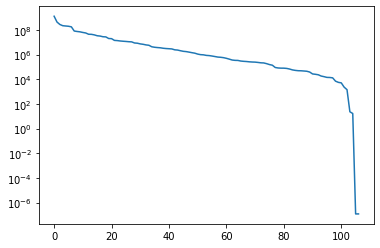

In [84]:
import seaborn as sns
import matplotlib.pyplot as plt

#sns.lineplot(np.log(S))
#sns.lineplot(y=S)
plt.plot(S)
plt.yscale("log")
plt.show()

In [85]:
cds = np.cumsum(S) / np.sum(S)
r90 = np.min(np.where(cds > 0.90))
r90

14

In [86]:
def omega_approx(beta):
    """Return an approximate omega value for given beta. Equation (5) from Gavish 2014."""
    return 0.56 * beta**3 - 0.95 * beta**2 + 1.82 * beta + 1.43

def svht(X, sigma=None, sv=None):
    """Return the optimal singular value hard threshold (SVHT) value.
    `X` is any m-by-n matrix. `sigma` is the standard deviation of the 
    noise, if known. Optionally supply the vector of singular values `sv`
    for the matrix (only necessary when `sigma` is unknown). If `sigma`
    is unknown and `sv` is not supplied, then the method automatically
    computes the singular values."""

    try:
        m,n = sorted(X.shape) # ensures m <= n
    except:
        raise ValueError('invalid input matrix')
    beta = m / n # ratio between 0 and 1
    if sigma is None: # sigma unknown
        if sv is None:
            sv = svdvals(X)
        sv = np.squeeze(sv)
        if sv.ndim != 1:
            raise ValueError('vector of singular values must be 1-dimensional')
        return np.median(sv) * omega_approx(beta)
    else: # sigma known
        return lambda_star(beta) * np.sqrt(n) * sigma

# find tau star hat when sigma is unknown
# tau = svht(D, sv=sv)

# # find tau star when sigma is known
# tau = svht(D, sigma=0.5)

In [87]:
tau = svht(mat, sv=S)

In [88]:
tau

1463934.7477145544

In [89]:
rank = np.sum(S > tau)
rank

48

In [37]:
import copy
newmat = np.zeros(mat.shape)
#print(newmat.shape)
for col in range(mat.shape[1]):
    #print(col)
    curcol = copy.deepcopy(mat[:,col])
    #print(curcol.shape)
    indices = np.random.choice(np.arange(curcol.size), replace=False,
                           size=int(curcol.size * 0.2))
    curcol[indices] = 0.0
    newmat[:,col] = curcol

In [38]:
mat.shape

(107, 624)

In [39]:
newmat.shape

(107, 624)

In [90]:
def qerr(mat, newmat):
    mat = np.maximum(mat, 1)
    newmat = np.maximum(newmat, 1)
    print(mat.shape)
    return np.mean(np.maximum (mat / newmat, newmat / mat))

In [91]:
qerr(mat, newmat)

(107, 624)


377780.49820273183

In [92]:
newmat = np.maximum(newmat, 1)
np.min(newmat)

1.0

In [66]:
np.min(newmat)

1.0

In [73]:
np.min(newmat)

1.0

In [75]:
np.max(mat)

inf

In [76]:
mat

array([[3.6244344e+07, 3.6244344e+07, 3.6244344e+07, ..., 3.6244344e+07,
        3.6244344e+07, 3.6244344e+07],
       [1.0570000e+03, 9.6660000e+03, 3.7080000e+03, ..., 1.1528000e+04,
        1.2643800e+05, 1.1000000e+02],
       [2.3532000e+04,           inf, 4.9768000e+04, ..., 1.9617140e+06,
        1.5435600e+05, 3.7640000e+04],
       ...,
       [3.2059360e+06,           inf, 1.7395790e+06, ...,           inf,
        1.7395790e+06,           inf],
       [2.0000000e+00,           inf, 2.0000000e+00, ...,           inf,
                  inf, 1.0000000e+00],
       [4.5156900e+05, 1.0398000e+05, 9.8978700e+05, ..., 2.0046120e+06,
        5.3823900e+05, 2.0186660e+06]])